# Predict how long a trip will take
# Predict how much the trip will cost

- predicting duration in seconds
    - why is this useful???
    - cannot include fees which are restrospective features
    - if this were to be in production, which features do we feed our model??
- predicting fare amount a better problem???

- measure error with rmsle
- train with May 2019
- test with June 2019

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load data

In [2]:
df = pd.read_csv('datasets/green_tripdata_2019-05.csv', parse_dates=['lpep_pickup_datetime', 'lpep_dropoff_datetime'])
df = df[df.RatecodeID == 1]    # assume we'll feed this model only RateCodeId == 1
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493058 entries, 0 to 504886
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               493058 non-null  int64         
 1   lpep_pickup_datetime   493058 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  493058 non-null  datetime64[ns]
 3   store_and_fwd_flag     493058 non-null  object        
 4   RatecodeID             493058 non-null  int64         
 5   PULocationID           493058 non-null  int64         
 6   DOLocationID           493058 non-null  int64         
 7   passenger_count        493058 non-null  int64         
 8   trip_distance          493058 non-null  float64       
 9   fare_amount            493058 non-null  float64       
 10  extra                  493058 non-null  float64       
 11  mta_tax                493058 non-null  float64       
 12  tip_amount             493058 non-null  floa

In [3]:
LOCATION_LOOKUP = pd.read_csv('datasets/taxi+_zone_lookup.csv')
LOCATION_LOOKUP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    265 non-null    int64 
 1   Borough       265 non-null    object
 2   Zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.4+ KB


# Look at features

- Pickup & drop off time
    - use these two features to derive our target variable = duration
    - can derive hour of the day that can be useful
- Location ID
    - can we tell much about these??
- RateCodeId
    - we'll look at 'Standard rate' only
    - other code will have different fees calculation
- fees related stuff should be correlated in some way, look to select only a few
    - fare_amount - calculated by meter
    - extra - 0.5 for rush hour and 1 for overnight (let's try to binarize these)
    - tip_amount - cash tips not included
    - tolls_amount - tools fee
    - mta_tax, improvement_surcharge --> constant
    - ehail_fee all null
    - congestion_surcharge - can this help indicate traffic

    - total_amount = total that customer paid except tips (can only use this for basic model)


- Discard some features
    - VendorID
        - let's assume that they all have similar drivers and release schedules
        - this may be an issue if some vendors have only night shifts = less traffic
    - store_and_fwd_code
        - purely about data submission
    - RateCodeId
        - we've already used this for filtering (we currently focus on Standard rate)
    - passenger_count
        - should have no influence on trip distance????????
    - mta_tax, improvement_surcharge
        - constant
    - tip_amount
        - remove because cash trips are not included in the data
    - payment type
    - trip_type
        - street hail or dispatch should not have influence on duration
        - duration is calculated from 

# Basic model

## Feature engineering
- derive target variable
- join location id to lookup table
    - and get borough name only??
    - will this help much??
- weekend binary
- rush hour, working hours, overnight bins

In [4]:
def get_pu_do_boroughs(df, location_lookup=LOCATION_LOOKUP):
    df_get_pu_borough = pd.merge(df, location_lookup, how='inner', left_on='PULocationID', right_on='LocationID').loc[:, list(df.columns)+['Borough']]
    df_get_pu_borough.rename(columns={'Borough':'PUBorough'}, inplace=True)

    df_get_do_borough = pd.merge(df_get_pu_borough, location_lookup, how='inner', left_on='DOLocationID', right_on='LocationID').loc[:, list(df_get_pu_borough.columns)+['Borough']]
    df_get_do_borough.rename(columns={'Borough':'DOBorough'}, inplace=True)

    return df_get_do_borough 

def feature_engineering(df):
    df = get_pu_do_boroughs(df)

    df = df.assign(is_weekend=df.lpep_pickup_datetime.dt.dayofweek.isin([5,6]))
    df = df.assign(is_rush=df.lpep_pickup_datetime.dt.hour.isin(range(16,20+1)) & ~df.is_weekend)
    df = df.assign(is_overnight=df.lpep_pickup_datetime.dt.hour.isin(list(range(20,23+1)) + list(range(0,8+1))))

    return df

def derive_target_var(df):
    # add target var column to df
    return df.assign(trip_duration_min=(df.loc[:, 'lpep_dropoff_datetime'] - df.loc[:, 'lpep_pickup_datetime']).dt.seconds / 60)


eda_df = derive_target_var(feature_engineering(df))
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493058 entries, 0 to 493057
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               493058 non-null  int64         
 1   lpep_pickup_datetime   493058 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  493058 non-null  datetime64[ns]
 3   store_and_fwd_flag     493058 non-null  object        
 4   RatecodeID             493058 non-null  int64         
 5   PULocationID           493058 non-null  int64         
 6   DOLocationID           493058 non-null  int64         
 7   passenger_count        493058 non-null  int64         
 8   trip_distance          493058 non-null  float64       
 9   fare_amount            493058 non-null  float64       
 10  extra                  493058 non-null  float64       
 11  mta_tax                493058 non-null  float64       
 12  tip_amount             493058 non-null  floa

## EDA

In [5]:
eda_df[eda_df.trip_distance == 0]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,total_amount,payment_type,trip_type,congestion_surcharge,PUBorough,DOBorough,is_weekend,is_rush,is_overnight,trip_duration_min
906,1,2019-05-05 16:49:32,2019-05-05 16:57:59,N,1,41,42,2,0.0,6.5,...,7.30,2,1,0.0,Manhattan,Manhattan,True,False,False,8.450000
929,1,2019-05-05 18:48:28,2019-05-05 18:53:56,N,1,41,42,3,0.0,5.0,...,5.80,2,1,0.0,Manhattan,Manhattan,True,False,False,5.466667
1039,2,2019-05-06 19:04:21,2019-05-06 19:11:58,N,1,41,42,1,0.0,6.0,...,7.80,2,1,0.0,Manhattan,Manhattan,False,True,False,7.616667
1851,2,2019-05-11 20:52:35,2019-05-11 21:02:59,N,1,41,42,1,0.0,7.5,...,8.80,1,1,0.0,Manhattan,Manhattan,True,False,True,10.400000
2812,1,2019-05-17 19:58:25,2019-05-17 20:07:03,N,1,41,42,2,0.0,6.5,...,7.80,2,1,0.0,Manhattan,Manhattan,False,True,False,8.633333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492945,1,2019-05-18 13:23:17,2019-05-18 14:52:49,N,1,61,46,1,0.0,60.2,...,67.12,1,1,0.0,Brooklyn,Bronx,True,False,False,89.533333
492981,1,2019-05-11 17:10:48,2019-05-11 17:27:20,N,1,184,46,1,0.0,65.2,...,72.12,1,1,0.0,Bronx,Bronx,True,False,False,16.533333
492983,1,2019-05-18 19:23:27,2019-05-18 19:24:09,N,1,46,46,1,0.0,55.2,...,56.00,1,1,0.0,Bronx,Bronx,True,False,False,0.700000
492985,1,2019-05-29 19:21:06,2019-05-29 19:25:45,N,1,46,46,1,0.0,65.2,...,66.00,1,1,0.0,Bronx,Bronx,False,True,False,4.650000


In [6]:
eda_df[eda_df.trip_duration_min == 0]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,total_amount,payment_type,trip_type,congestion_surcharge,PUBorough,DOBorough,is_weekend,is_rush,is_overnight,trip_duration_min
7463,1,2019-05-19 20:33:09,2019-05-19 20:33:09,N,1,42,42,1,0.0,55.2,...,56.00,1,1,0.0,Manhattan,Manhattan,True,False,True,0.0
7652,1,2019-05-21 15:31:44,2019-05-21 15:31:44,N,1,42,42,1,0.0,2.5,...,3.30,2,1,0.0,Manhattan,Manhattan,False,False,False,0.0
27574,2,2019-05-04 23:20:04,2019-05-04 23:20:04,N,1,75,75,1,0.0,2.5,...,3.80,2,1,0.0,Manhattan,Manhattan,True,False,True,0.0
59969,1,2019-05-11 13:50:53,2019-05-11 13:50:53,N,1,41,41,1,0.7,5.5,...,6.30,2,1,0.0,Manhattan,Manhattan,True,False,False,0.0
61498,1,2019-05-23 22:33:42,2019-05-23 22:33:42,N,1,41,41,1,1.1,6.0,...,8.30,1,1,0.0,Manhattan,Manhattan,False,False,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429985,1,2019-05-02 08:18:26,2019-05-02 08:18:26,N,1,40,25,1,0.0,50.0,...,50.80,1,1,0.0,Brooklyn,Brooklyn,False,False,True,0.0
433771,2,2019-05-17 15:31:47,2019-05-17 15:31:47,N,1,215,215,1,0.0,-2.5,...,-3.30,3,1,0.0,Queens,Queens,False,False,False,0.0
433772,2,2019-05-17 15:31:47,2019-05-17 15:31:47,N,1,215,215,1,0.0,2.5,...,3.30,2,1,0.0,Queens,Queens,False,False,False,0.0
465843,1,2019-05-18 11:39:35,2019-05-18 11:39:35,N,1,72,72,1,0.0,55.2,...,62.12,1,1,0.0,Brooklyn,Brooklyn,True,False,False,0.0


In [7]:
def remove_zero_distance(df):
    '''
    remove zeros for trip_distance
    zeros seem like data record error
    '''
    return df[df['trip_distance'] != 0]
def remove_zero_duration(df):
    '''
    remove zeros for trip_duration_min
    zeros seem like data record error
    '''
    return df[df['trip_duration_min'] != 0]   
def remove_outliers_distance(df):
    '''
    remove outliers for trip_distance
    remove top values greater or less than 3 std
    '''
    trip_distance_mean, trip_distance_std = df['trip_distance'].mean(), df['trip_distance'].std()
    trip_distance_lower = trip_distance_mean - 3*trip_distance_std
    trip_distance_upper = trip_distance_mean + 3*trip_distance_std
    return df[(df['trip_distance'] < trip_distance_upper) & (df['trip_distance'] > trip_distance_lower)]
def remove_outliers_duration(df):
    '''
    remove outliers for trip_duration_min
    remove top values greater or less than 3 std
    '''
    trip_distance_mean, trip_distance_std = df['trip_duration_min'].mean(), df['trip_duration_min'].std()
    trip_distance_lower = trip_distance_mean - 3*trip_distance_std
    trip_distance_upper = trip_distance_mean + 3*trip_distance_std
    return df[(df['trip_duration_min'] < trip_distance_upper) & (df['trip_duration_min'] > trip_distance_lower)]
def remove_zero_outliers(df):
    return remove_outliers_duration(remove_outliers_distance(remove_zero_duration(remove_zero_distance(df))))
eda_df = remove_zero_outliers(eda_df)
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472657 entries, 0 to 493057
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               472657 non-null  int64         
 1   lpep_pickup_datetime   472657 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  472657 non-null  datetime64[ns]
 3   store_and_fwd_flag     472657 non-null  object        
 4   RatecodeID             472657 non-null  int64         
 5   PULocationID           472657 non-null  int64         
 6   DOLocationID           472657 non-null  int64         
 7   passenger_count        472657 non-null  int64         
 8   trip_distance          472657 non-null  float64       
 9   fare_amount            472657 non-null  float64       
 10  extra                  472657 non-null  float64       
 11  mta_tax                472657 non-null  float64       
 12  tip_amount             472657 non-null  floa

Text(0, 0.5, 'Trips')

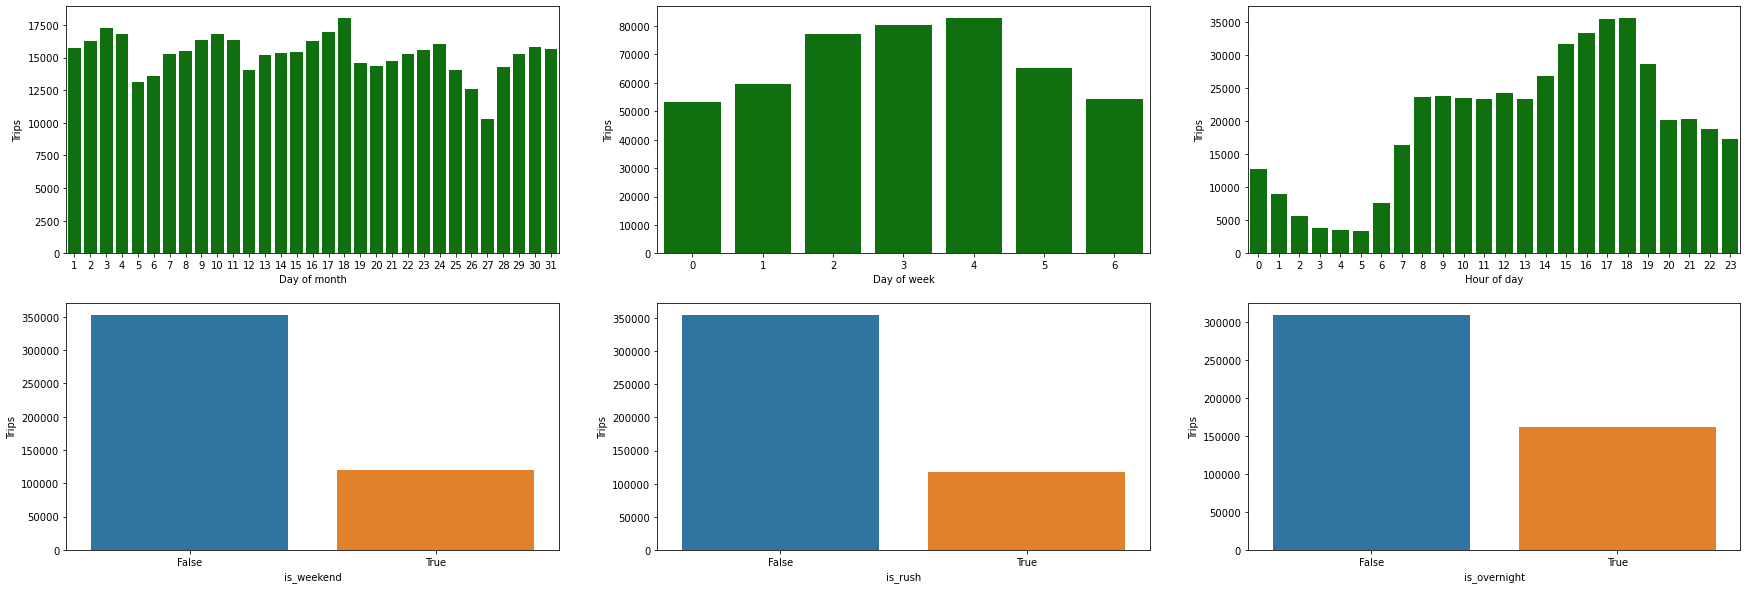

In [8]:
# number of trips by

plt.figure(figsize=(30,10))
# date of month (end of month people use cab more, or run out of money use subway haha)
plt.subplot(231)
sns.countplot(x=eda_df.lpep_pickup_datetime.dt.day, color='green')
plt.xlabel('Day of month')
plt.ylabel('Trips')
# day of week
plt.subplot(232)
sns.countplot(x=eda_df.lpep_pickup_datetime.dt.day_of_week, color='green')
plt.xlabel('Day of week')
plt.ylabel('Trips')
# hour of day
plt.subplot(233)
sns.countplot(x=eda_df.lpep_pickup_datetime.dt.hour, color='green')
plt.xlabel('Hour of day')
plt.ylabel('Trips')

# weekdays and weekends
plt.subplot(234)
sns.countplot(x=eda_df.is_weekend)
plt.ylabel('Trips')
# rush hour
plt.subplot(235)
sns.countplot(x=eda_df.is_rush)
plt.ylabel('Trips')
# overnight
plt.subplot(236)
sns.countplot(x=eda_df.is_overnight)
plt.ylabel('Trips')

<Figure size 1440x360 with 0 Axes>

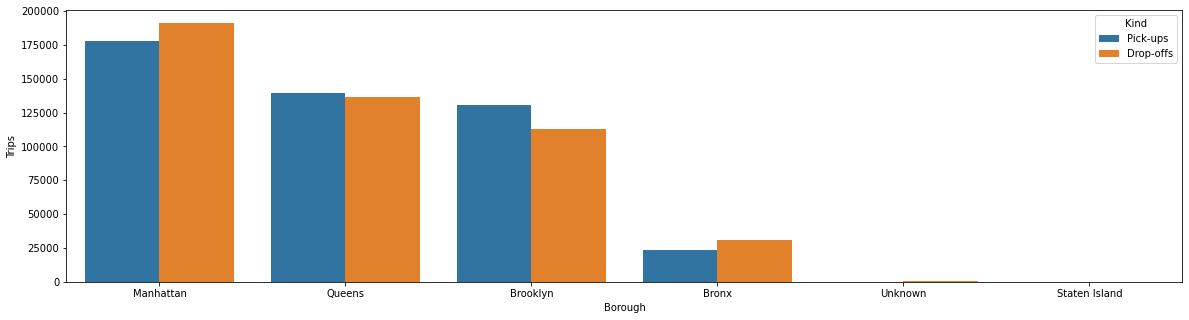

In [9]:
# Pickup and drop off location by boroughs
def plot_trips_by_locations(df):
    plt.figure(figsize=(20,5))

    pickups = df.PUBorough.value_counts().to_frame().reset_index()
    pickups.columns = ['Borough', 'Trips']
    pickups.loc[:,'Kind'] = 'Pick-ups'
    
    dropoffs = df.DOBorough.value_counts().to_frame().reset_index()
    dropoffs.columns = ['Borough', 'Trips']
    dropoffs.loc[:,'Kind'] = 'Drop-offs'
    
    combined = pd.concat([pickups, dropoffs], axis=0)

    plt.figure(figsize=(20,5))
    sns.barplot(data=combined, x='Borough', y='Trips', hue='Kind', estimator=np.sum)
    plt.show()

plot_trips_by_locations(eda_df)

<AxesSubplot:xlabel='trip_duration_min'>

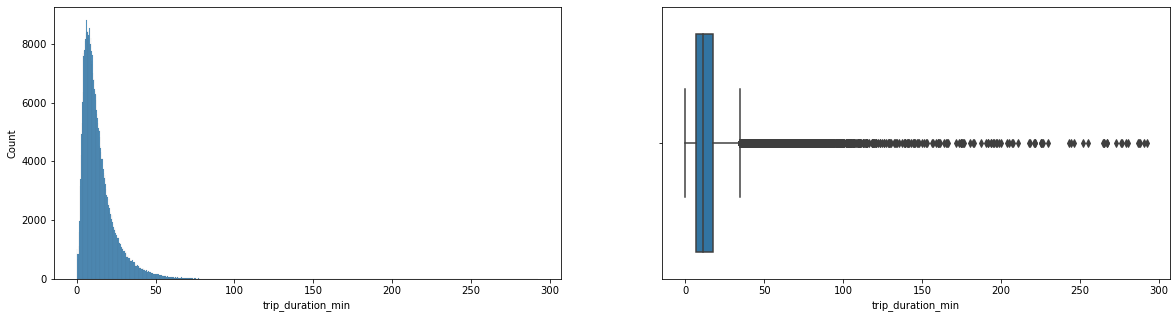

In [10]:
# trip duration distribution after removing zeros and outliers
plt.figure(figsize=(20,5))
plt.subplot(121); sns.histplot(data=eda_df, x='trip_duration_min')
plt.subplot(122); sns.boxplot(data=eda_df, x='trip_duration_min')

<AxesSubplot:xlabel='trip_distance'>

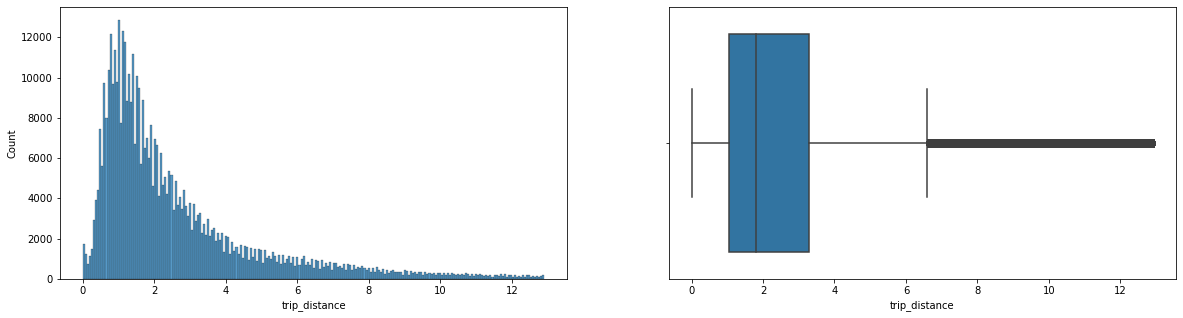

In [11]:
# trip distance after removing zeros and outliers
plt.figure(figsize=(20,5))
plt.subplot(121); sns.histplot(data=eda_df, x='trip_distance')
plt.subplot(122); sns.boxplot(data=eda_df, x='trip_distance')

<AxesSubplot:xlabel='trip_distance', ylabel='trip_duration_min'>

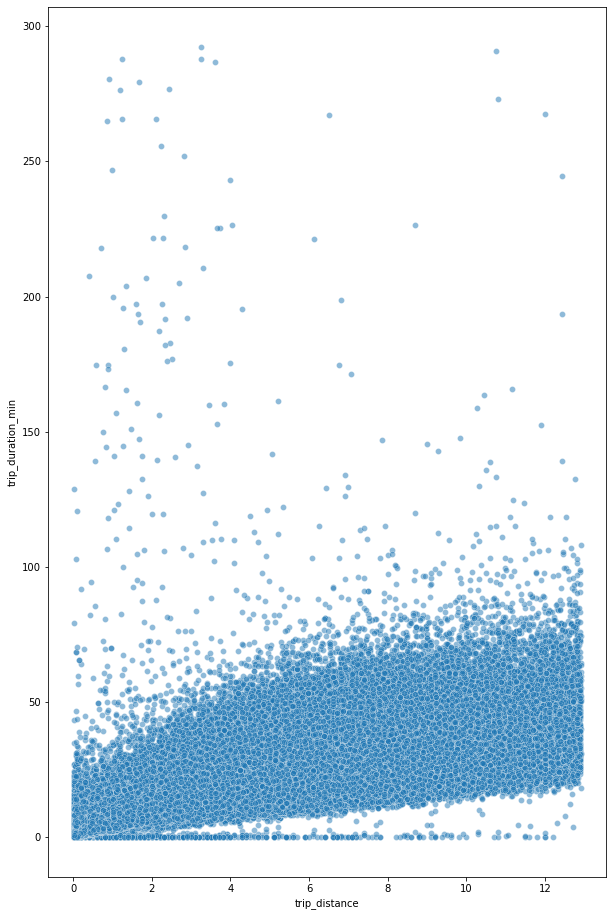

In [64]:
# trip duration vs trip distance
plt.figure(figsize=(10,16))
sns.scatterplot(data=eda_df, x='trip_distance', y='trip_duration_min', alpha=0.5)


fairly linear

## Preprocessing pipeline
- work from df, this is the data format we will get

- df --> X, y
    - feature engineering
    - train test split
    - remove outliers and zeros from training set
    - separate X, y

In [127]:
from sklearn.model_selection import train_test_split

X_cols = ['trip_distance', 'is_weekend', 'is_rush', 'is_overnight']
y_cols = ['trip_duration_min']
model_df_cols = X_cols + y_cols

model_df = derive_target_var(feature_engineering(df))[model_df_cols]

df_train, df_test = train_test_split(model_df, test_size=0.1, random_state=9)  # in real life we should pull test from another place

In [128]:
df_train = remove_zero_outliers(df_train)
df_train = remove_zero_outliers(df_train)

In [129]:
X_train, y_train = df_train[X_cols], df_train[y_cols]
X_test, y_test = df_test[X_cols], df_test[y_cols]

In [156]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

X_cols_num = ['trip_distance']
X_cols_cat = [] # ['PUBorough', 'DOBorough']
X_cols_bypass = ['is_weekend', 'is_rush', 'is_overnight']

num_pipeline = Pipeline(
    steps=[
        ('selector', FunctionTransformer(lambda x: x[X_cols_num])),
        # ('standard_scaler', StandardScaler())
        # ('power_transformer', PowerTransformer())
])

cat_pipeline = Pipeline(
    steps=[
        ('selector', FunctionTransformer(lambda x: x[X_cols_cat]))
])

bypass_pipeline = Pipeline(
    steps=[
        ('selector', FunctionTransformer(lambda x: x[X_cols_bypass]))
])

pp_pipeline = Pipeline([
    ('union', FeatureUnion([('numeric', num_pipeline), ('cat', cat_pipeline), ('bypass', bypass_pipeline)]))
])
        
X_train_pp = pp_pipeline.fit_transform(X_train)
X_test_pp = pp_pipeline.transform(X_test)

In [157]:
X_train_pp

array([[1.6 , 1.  , 0.  , 1.  ],
       [1.1 , 0.  , 1.  , 0.  ],
       [0.82, 1.  , 0.  , 0.  ],
       ...,
       [2.41, 0.  , 1.  , 0.  ],
       [1.6 , 0.  , 0.  , 1.  ],
       [1.63, 0.  , 0.  , 0.  ]])

<AxesSubplot:ylabel='Count'>

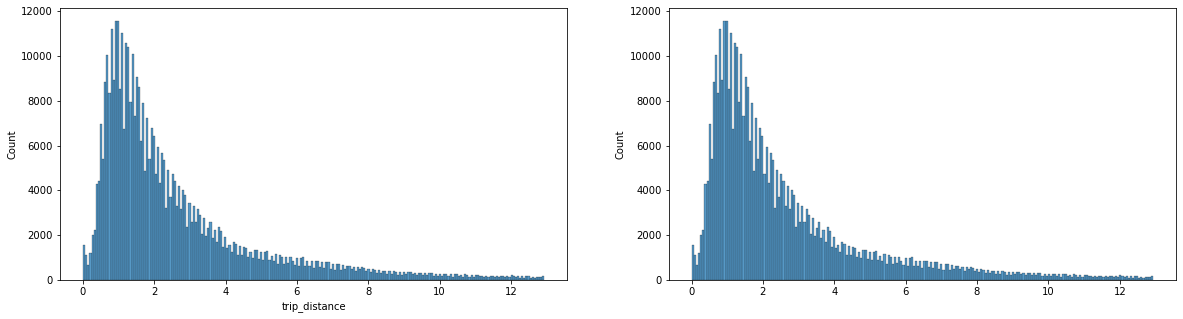

In [158]:
plt.figure(figsize=(20,5))
plt.subplot(121); sns.histplot(data=X_train, x='trip_distance')
plt.subplot(122); sns.histplot(x=X_train_pp[:, 0])

## Fit basic model

measure error by lmrse

- try linear regression
- try ridge regression
- try decistion tree regressor
- random forest regressor

In [159]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [166]:
def evaluate_regressor(regressor, X_train, y_train, X_test, y_test):
    regressor.fit(X_train, y_train)
    # make predictions on training data
    y_pred_train = regressor.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmlse_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
    # make predictions on test data
    y_pred_test = regressor.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    rmlse_test = np.sqrt(mean_squared_log_error(y_test, y_pred_test))

    print(f'Predicting with {regressor}')
    print('Training error:')
    print(f'Root mean squared error = {rmse_train} min^2')
    print(f'Root mean squared log error = {rmlse_train}')
    print('Testing error:')
    print(f'Root mean squared error = {rmse_test} min^2')
    print(f'Root mean squared log error = {rmlse_test}')

In [167]:
from sklearn.linear_model import LinearRegression

evaluate_regressor(LinearRegression(), X_train_pp, y_train, X_test_pp, y_test)

Predicting with LinearRegression()
Training error:
Root mean squared error = 6.75298367605926 min^2
Root mean squared log error = 0.3715105230538341
Testing error:
Root mean squared error = 89.12992075476072 min^2
Root mean squared log error = 0.5098100253915647


- single numeric feature don't need scaling
- lin reg underfit

In [168]:
from sklearn.linear_model import Lasso

evaluate_regressor(Lasso(), X_train_pp, y_train, X_test_pp, y_test)

print(Lasso().fit(X_train_pp, y_train).coef_)

Predicting with Lasso()
Training error:
Root mean squared error = 6.938530891476174 min^2
Root mean squared log error = 0.3905431333520307
Testing error:
Root mean squared error = 89.14798106571476 min^2
Root mean squared log error = 0.5213228934643532
[ 3.51838681 -0.          0.         -0.        ]


- our generated cat features did not help

In [169]:
from sklearn.tree import DecisionTreeRegressor

evaluate_regressor(DecisionTreeRegressor(), X_train_pp, y_train, X_test_pp, y_test)

Predicting with DecisionTreeRegressor()
Training error:
Root mean squared error = 6.285629214731895 min^2
Root mean squared log error = 0.31634418150393717
Testing error:
Root mean squared error = 89.22929715706407 min^2
Root mean squared log error = 0.48324623232424924


In [188]:
from sklearn.ensemble import RandomForestRegressor

evaluate_regressor(RandomForestRegressor(), X_train_pp, y_train.to_numpy().ravel(), X_test_pp, y_test.to_numpy().ravel())
# rf = RandomForestRegressor()
# rf.fit(X_train_pp, y_train.to_numpy().ravel())
# y_train.to_numpy().ravel()

Predicting with RandomForestRegressor()
Training error:
Root mean squared error = 6.289078540184267 min^2
Root mean squared log error = 0.31643270573291343
Testing error:
Root mean squared error = 89.22495740227357 min^2
Root mean squared log error = 0.4829197399880682
